### Bio-Optical and Nutrient Indicators

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/fitur_clean/porosity.csv')

In [3]:
# Convert date column to datetime
df['depth_reading_time'] = pd.to_datetime(df['depth_reading_time'])

# Select only numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

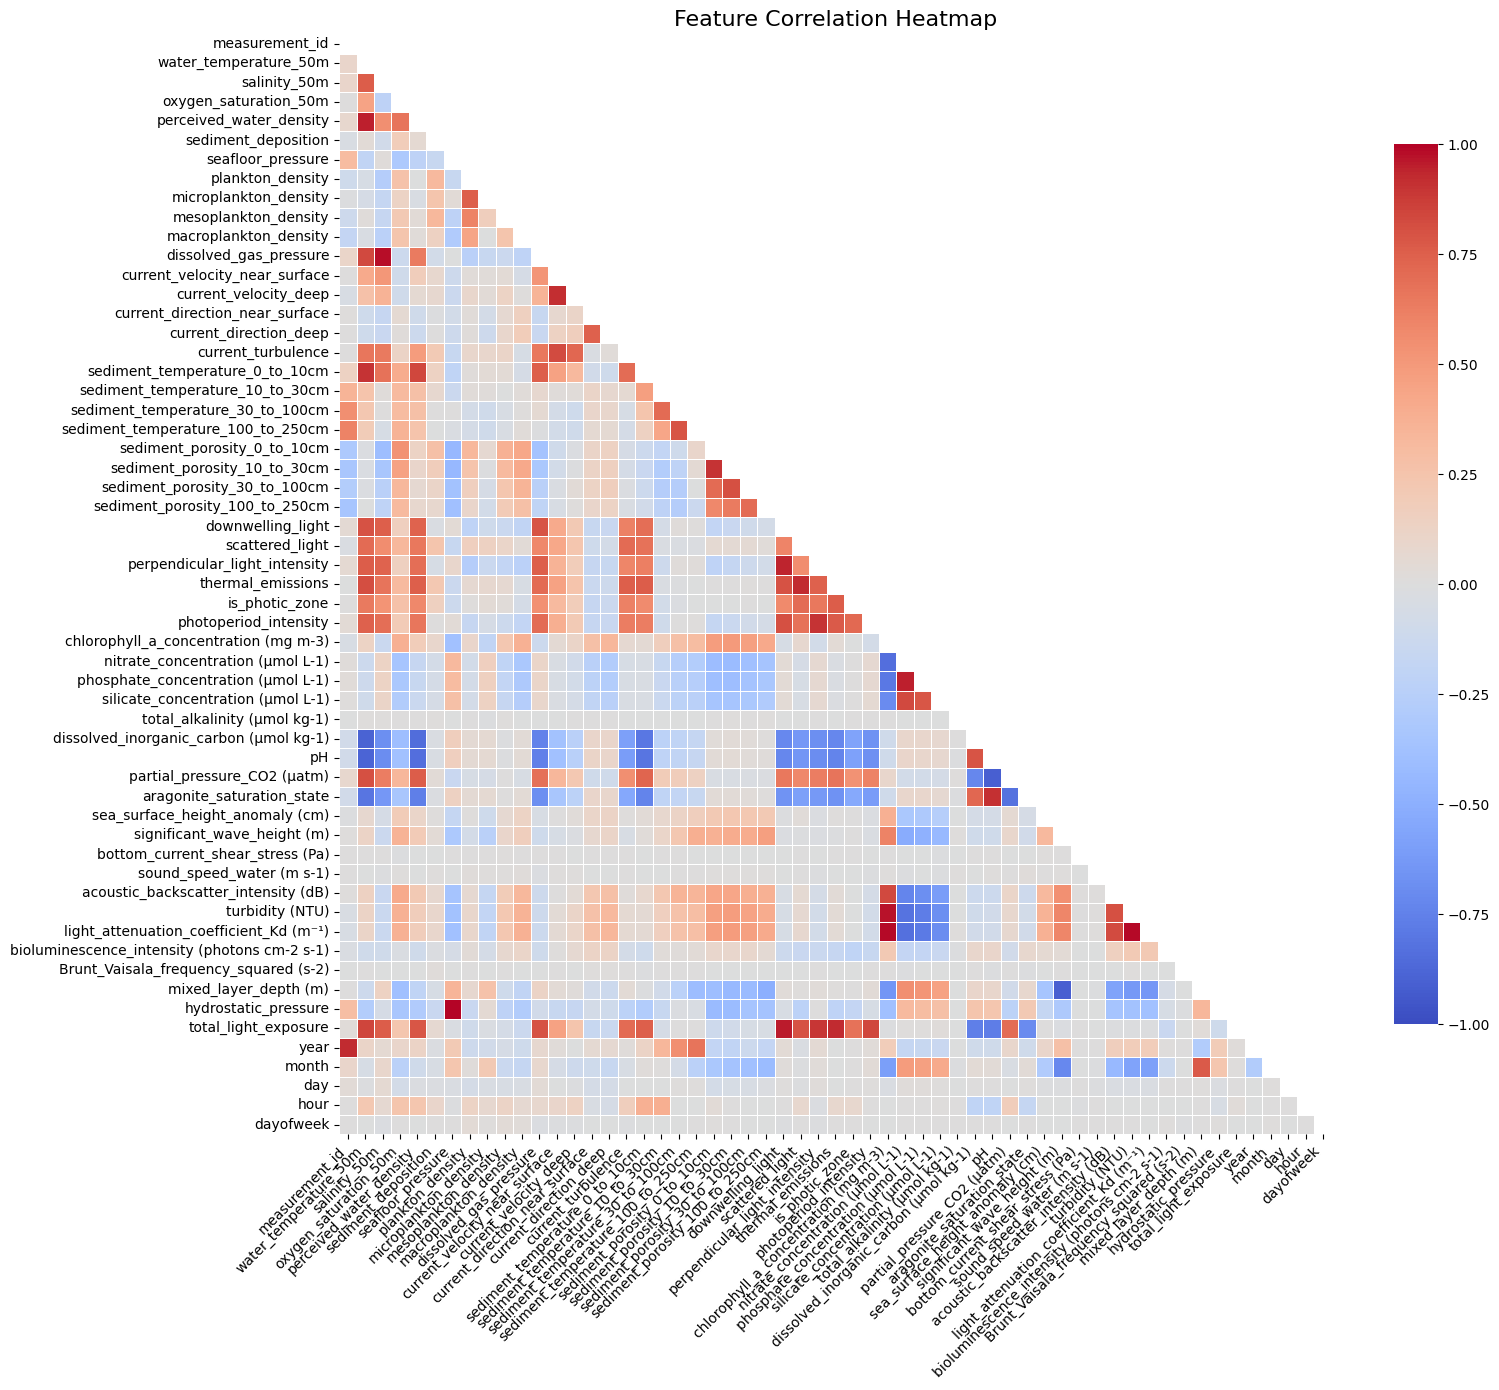

In [4]:
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', 
            vmin=-1, vmax=1, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
# Calculate VIF for numeric columns
# First, drop NaN values
df_vif = df[numeric_cols].dropna()

# If there are too many columns, select a subset
if len(df_vif.columns) > 30:
    # Remove year, month, day, hour columns from VIF analysis as they're temporal
    vif_cols = [col for col in df_vif.columns if col not in ['year', 'month', 'day', 'hour', 'dayofweek', 'measurement_id']]
    
    # Take columns with fewer NaN values (most complete data)
    vif_cols = sorted(vif_cols, key=lambda col: df[col].isna().sum())[:25]
    df_vif = df[vif_cols].dropna()

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

# Sort by VIF and display
vif_data = vif_data.sort_values("VIF", ascending=False)
print("Variance Inflation Factors (VIF):")
print(vif_data)

# Identify features with high multicollinearity (VIF > 10)
high_vif = vif_data[vif_data["VIF"] > 10]
print("\nFeatures with high multicollinearity (VIF > 10):")
print(high_vif)

Variance Inflation Factors (VIF):
                                  feature            VIF
15       sediment_temperature_30_to_100cm  271878.944004
23        sediment_temperature_10_to_30cm  259170.968581
21              sound_speed_water (m s-1)   22626.263974
14           total_alkalinity (µmol kg-1)   11180.074854
10                   total_light_exposure    2997.340073
4                       downwelling_light    1489.214249
13                perceived_water_density     430.472233
5                         scattered_light     410.217012
22    acoustic_backscatter_intensity (dB)     341.244106
3          sediment_porosity_100_to_250cm     164.212160
18       nitrate_concentration (µmol L-1)      99.876611
1            sediment_porosity_10_to_30cm      95.424822
0             sediment_porosity_0_to_10cm      80.944669
16                        turbidity (NTU)      69.081801
2           sediment_porosity_30_to_100cm      63.429016
11   chlorophyll_a_concentration (mg m-3)      58.4543

In [6]:
features_concentration = [
'chlorophyll_a_concentration (mg m-3)',
'nitrate_concentration (µmol L-1)',
'phosphate_concentration (µmol L-1)',
'silicate_concentration (µmol L-1)',
'acoustic_backscatter_intensity (dB)',
'turbidity (NTU)',
'light_attenuation_coefficient_Kd (m⁻¹)'
]

In [7]:
# Pastikan kolom-kolom ini ada di DataFrame
missing_cols = [col for col in features_concentration if col not in df.columns]
if missing_cols:
    print(f"Kolom berikut tidak ditemukan di DataFrame dan akan dilewati: {missing_cols}")
    features_concentration = [col for col in features_concentration if col in df.columns]

if not features_concentration:
    print("Tidak ada fitur porositas yang valid untuk diimputasi.")
else:
    # Buat subset DataFrame hanya dengan fitur yang akan diimputasi
    # dan simpan indeks aslinya
    df_subset_porosity = df[features_concentration].copy()
    original_index_porosity = df_subset_porosity.index

    # Simpan kondisi NaN awal untuk perbandingan
    nan_mask_porosity_original = df_subset_porosity.isnull()

    print("Missing values SEBELUM imputasi KNN (fitur porositas):")
    print(df_subset_porosity.isnull().sum().loc[lambda x: x > 0])
    print("-" * 30)

    # Hanya lanjutkan jika ada missing values
    if df_subset_porosity.isnull().any().any():
        # 1. Scaling
        # Karena KNN sensitif terhadap skala, scaling penting.
        scaler_porosity = StandardScaler()
        # Simpan nama kolom sebelum scaling
        scaled_columns_porosity = df_subset_porosity.columns
        df_scaled_porosity_array = scaler_porosity.fit_transform(df_subset_porosity)
        df_scaled_porosity = pd.DataFrame(df_scaled_porosity_array, columns=scaled_columns_porosity, index=original_index_porosity)

        # 2. Imputasi menggunakan KNNImputer
        # n_neighbors=3 atau 5 adalah nilai awal yang baik.
        # Pastikan n_neighbors tidak lebih besar dari jumlah sampel non-NaN yang tersedia.
        # Jika jumlah baris sangat sedikit, kurangi n_neighbors.
        n_samples = len(df_scaled_porosity)
        k_neighbors = min(5, n_samples - 1 if n_samples > 1 else 1)

        imputer_porosity = KNNImputer(n_neighbors=k_neighbors)

        # Imputer akan mengembalikan numpy array
        df_imputed_scaled_porosity_array = imputer_porosity.fit_transform(df_scaled_porosity)

        # Konversi kembali ke DataFrame
        df_imputed_scaled_porosity = pd.DataFrame(df_imputed_scaled_porosity_array, columns=scaled_columns_porosity, index=original_index_porosity)

        # 3. Kembalikan ke skala semula (inverse transform)
        df_imputed_original_scale_porosity_array = scaler_porosity.inverse_transform(df_imputed_scaled_porosity)
        df_imputed_original_scale_porosity = pd.DataFrame(df_imputed_original_scale_porosity_array, columns=scaled_columns_porosity, index=original_index_porosity)

        # 4. Gabungkan kembali nilai yang sudah diimputasi ke DataFrame df utama
        for col in features_concentration:
            df.loc[original_index_porosity, col] = df_imputed_original_scale_porosity[col]

        print("\nMissing values SETELAH imputasi KNN (fitur porositas):")
        print(df[features_concentration].isnull().sum().loc[lambda x: x > 0]) # Harusnya kosong jika semua terimputasi
        print("-" * 30)

        # --- TAMPILKAN PERBANDINGAN ---
        print("Perbandingan SEBELUM dan SESUDAH imputasi KNN (hanya nilai yang diimputasi pada fitur porositas):")
        any_imputed_porosity = False
        for feature in features_concentration:
            # Dapatkan indeks dari df_subset_porosity (original_index_porosity) di mana fitur ini awalnya NaN
            idx_nan_in_feature_porosity = nan_mask_porosity_original[nan_mask_porosity_original[feature]].index

            if not idx_nan_in_feature_porosity.empty:
                any_imputed_porosity = True
                print(f"\n--- Fitur: {feature} ---")
                # Nilai sebelum diambil dari salinan yang kita buat (df_subset_porosity sebelum modifikasi inplace)
                # atau lebih baik, dari df_subset_porosity yang dibuat di awal
                before_values = df_subset_porosity.loc[idx_nan_in_feature_porosity, feature]
                # Nilai sesudah diambil dari df utama yang sudah diupdate
                after_values = df.loc[idx_nan_in_feature_porosity, feature]

                comparison_df_porosity = pd.DataFrame({
                    'Indeks Asli': idx_nan_in_feature_porosity, # Untuk referensi ke baris asli
                    'Sebelum': before_values,
                    'Sesudah': after_values.round(4) # Pembulatan untuk tampilan
                }).set_index('Indeks Asli')
                print(comparison_df_porosity)
        if not any_imputed_porosity:
            print("Tidak ada nilai spesifik yang teridentifikasi telah diimputasi (mungkin tidak ada NaN awal pada fitur porositas).")

    else:
        print("Tidak ada missing values pada fitur porositas untuk diimputasi.")

Missing values SEBELUM imputasi KNN (fitur porositas):
chlorophyll_a_concentration (mg m-3)      1328
nitrate_concentration (µmol L-1)          1768
phosphate_concentration (µmol L-1)        4087
silicate_concentration (µmol L-1)         3994
acoustic_backscatter_intensity (dB)       2971
turbidity (NTU)                           1627
light_attenuation_coefficient_Kd (m⁻¹)    3909
dtype: int64
------------------------------

Missing values SETELAH imputasi KNN (fitur porositas):
Series([], dtype: int64)
------------------------------
Perbandingan SEBELUM dan SESUDAH imputasi KNN (hanya nilai yang diimputasi pada fitur porositas):

--- Fitur: chlorophyll_a_concentration (mg m-3) ---
             Sebelum  Sesudah
Indeks Asli                  
4                NaN   3.2012
7                NaN   3.2352
28               NaN   3.2626
42               NaN   3.2874
74               NaN   1.8927
...              ...      ...
21862            NaN   0.6200
21869            NaN   0.0100
21878    

In [8]:
print("\nDataFrame df setelah imputasi fitur porositas (cuplikan):")
print(df[features_concentration + ['hour']].head(10).to_string())


DataFrame df setelah imputasi fitur porositas (cuplikan):
   chlorophyll_a_concentration (mg m-3)  nitrate_concentration (µmol L-1)  phosphate_concentration (µmol L-1)  silicate_concentration (µmol L-1)  acoustic_backscatter_intensity (dB)  turbidity (NTU)  light_attenuation_coefficient_Kd (m⁻¹)  hour
0                              3.224434                          4.327586                            0.245655                           4.630902                           -61.838223         5.826377                                0.716677     0
1                              3.577219                          4.146822                            0.258023                           3.147517                           -65.513550         5.883116                                0.773086     1
2                              2.907752                          4.450997                            0.278808                           4.499263                           -61.667442         5.042899        

In [9]:
df.to_csv('data/fitur_clean/concentration.csv', index=False)